## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import time
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from cuml.ensemble import RandomForestRegressor as cuRF
from scripts.function_utils import last_energy_points, predict_results, prepare_polynomial, normalize_training, expanding_window_split, retrieve_selected_features, total_averaged_metrics, no_ml_predict

## Load Data

In [2]:
data = pd.read_excel("~/datasets/Dataset.xlsx", sheet_name=['Total Consumers'])
df = data['Total Consumers']
number_of_houses = len(df.columns)
df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,2.964,2.322959,1.544607,0.778310,1.962012,2.677445,0.237877,0.689194,0.358525,0.814643,...,0.898895,0.203825,0.221624,0.319531,0.830996,0.924987,0.219128,0.274880,0.990488,0.779475
1,2.584,2.371797,1.544607,0.778310,1.962012,2.733737,0.192929,0.558967,0.358525,0.660712,...,0.917793,0.165311,0.179747,0.319531,0.848467,0.944434,0.177722,0.222940,1.011313,0.795863
2,3.071,2.415961,1.319880,0.665072,1.676555,2.784640,0.382869,1.109272,0.377198,1.311186,...,0.934883,0.328060,0.356708,0.336174,0.864266,0.962019,0.352691,0.442426,1.030144,0.810682
3,2.694,2.302538,1.319880,0.665072,1.676555,2.653908,0.442052,1.280743,0.377198,1.513868,...,0.890992,0.378772,0.411848,0.336174,0.823691,0.916855,0.407209,0.510816,0.981781,0.772623
4,2.569,2.363063,0.913154,0.460128,1.159919,2.723669,0.192242,0.556976,0.668500,0.658358,...,0.914413,0.164722,0.179106,0.595793,0.845343,0.940956,0.177089,0.222146,1.007588,0.792932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35131,1.664,2.244719,1.455982,0.733653,1.849437,2.587266,0.205654,0.595835,0.171793,0.704291,...,0.868619,0.176214,0.191602,0.153109,0.803007,0.893832,0.189444,0.237645,0.957128,0.753222
35132,1.659,2.136340,1.201186,0.605264,1.525786,2.462348,0.201219,0.582985,0.067223,0.689101,...,0.826680,0.172414,0.187470,0.059912,0.764237,0.850676,0.185359,0.232519,0.910916,0.716855
35133,1.664,2.192805,1.201186,0.605264,1.525786,2.527430,0.228585,0.662271,0.067223,0.782819,...,0.848530,0.195862,0.212966,0.059912,0.784436,0.873160,0.210568,0.264142,0.934992,0.735802
35134,1.697,1.446083,0.259545,0.130782,0.329682,1.666757,0.189302,0.548459,0.070958,0.648292,...,0.559578,0.162203,0.176368,0.063241,0.517310,0.575820,0.174381,0.218749,0.616596,0.485237


In [3]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35131,49.211311
35132,43.139892
35133,44.599341
35134,28.956084


#### Example of past timesteps

In [4]:
Xt, yt = last_energy_points(df_total, 3)
Xt

,lag_1,lag_2,lag_3
0,63.011688,57.575249,58.514142
1,62.735722,63.011688,57.575249
2,63.404029,62.735722,63.011688
3,63.710440,63.404029,62.735722
4,50.544573,63.710440,63.404029
...,...,...,...
35128,62.642645,39.394640,42.250176
35129,49.211311,62.642645,39.394640
35130,43.139892,49.211311,62.642645
35131,44.599341,43.139892,49.211311


In [5]:
Xt_norm, _ = normalize_training(Xt)
Xt_norm

array([[0.36540976, 0.33113298, 0.33705271],
       [0.36366979, 0.36540976, 0.33113298],
       [0.36788347, 0.36366979, 0.36540976],
       ...,
       [0.24011798, 0.27839831, 0.36308294],
       [0.24931982, 0.24011798, 0.27839831],
       [0.15068901, 0.24931982, 0.24011798]])

In [6]:
yt

,Energy
0,62.735722
1,63.404029
2,63.710440
3,50.544573
4,49.966228
...,...
35128,49.211311
35129,43.139892
35130,44.599341
35131,28.956084


# No ML

In [7]:
X15 = df_total.copy()
X15 = X15.iloc[:-1]
X15.reset_index(drop=True, inplace=True)
X15

,Energy
0,58.514142
1,57.575249
2,63.011688
3,62.735722
4,63.404029
...,...
35130,62.642645
35131,49.211311
35132,43.139892
35133,44.599341


In [8]:
y15 = df_total.copy()
y15 = y15.iloc[1:]
y15.reset_index(drop=True, inplace=True)
y15

,Energy
0,57.575249
1,63.011688
2,62.735722
3,63.404029
4,63.710440
...,...
35130,49.211311
35131,43.139892
35132,44.599341
35133,28.956084


In [51]:
rmse_15, wape_15, r2_15 = no_ml_predict(X15.values, y15.values)

RMSE: 11.3868
WAPE: 19.97
R2: 0.6880


# Linear Regression

In [10]:
number_of_past_timesteps = 96

In [11]:
n_splits = 10

In [12]:
metrics_list_lr = []

X, y = last_energy_points(df_total, number_of_past_timesteps)

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, LinearRegression())
    metrics_list_lr.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 11.5090
WAPE: 19.88
R2: 0.7345

Elapsed time: 0.034 seconds

Iteration  1
RMSE: 11.5607
WAPE: 19.32
R2: 0.7077

Elapsed time: 0.044 seconds

Iteration  2
RMSE: 9.9568
WAPE: 20.97
R2: 0.6325

Elapsed time: 0.029 seconds

Iteration  3
RMSE: 9.7141
WAPE: 21.52
R2: 0.5175

Elapsed time: 0.033 seconds

Iteration  4
RMSE: 8.9376
WAPE: 21.65
R2: 0.5357

Elapsed time: 0.044 seconds

Iteration  5
RMSE: 8.2730
WAPE: 22.15
R2: 0.6066

Elapsed time: 0.048 seconds

Iteration  6
RMSE: 9.5784
WAPE: 20.10
R2: 0.5878

Elapsed time: 0.060 seconds

Iteration  7
RMSE: 10.6085
WAPE: 17.82
R2: 0.6739

Elapsed time: 0.085 seconds

Iteration  8
RMSE: 11.2139
WAPE: 17.95
R2: 0.7629

Elapsed time: 0.097 seconds

Iteration  9
RMSE: 12.2507
WAPE: 17.91
R2: 0.7550

Elapsed time: 0.092 seconds


In [13]:
rmse_lr, wape_lr, r2_lr = total_averaged_metrics(metrics_list_lr)

Total Averaged RMSE: 10.36
Total Averaged WAPE: 19.927
Total Averaged R2: 0.651


In [14]:
col1 = [row[0] for row in metrics_list_lr]
col2 = [row[1] for row in metrics_list_lr]
col3 = [row[2] for row in metrics_list_lr]

Text(0.5, 0, 'EW Iterations')

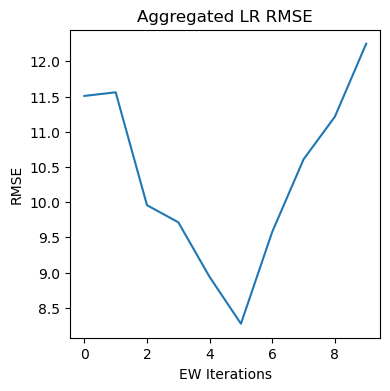

In [15]:
plt.figure(figsize=(4, 4)) 
plt.plot(col1)
plt.title('Aggregated LR RMSE')
plt.ylabel('RMSE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

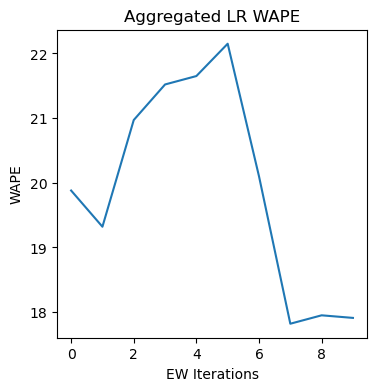

In [16]:
plt.figure(figsize=(4, 4)) 
plt.plot(col2)
plt.title('Aggregated LR WAPE')
plt.ylabel('WAPE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

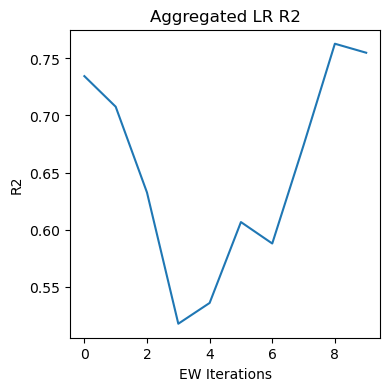

In [17]:
plt.figure(figsize=(4, 4)) 
plt.plot(col3)
plt.title('Aggregated LR R2')
plt.ylabel('R2')
plt.xlabel('EW Iterations')

# XGBoost

In [18]:
metrics_list_xgb = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, model_xgb = predict_results(X_train_norm, X_test_norm, y_train, y_test, xgb.XGBRegressor(seed=42, tree_method='gpu_hist'))
    metrics_list_xgb.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 12.8484
WAPE: 22.96
R2: 0.6691

Elapsed time: 1.594 seconds

Iteration  1
RMSE: 12.1498
WAPE: 20.56
R2: 0.6772

Elapsed time: 0.144 seconds

Iteration  2
RMSE: 10.6261
WAPE: 22.81
R2: 0.5814

Elapsed time: 0.146 seconds

Iteration  3
RMSE: 10.2400
WAPE: 23.01
R2: 0.4639

Elapsed time: 0.151 seconds

Iteration  4
RMSE: 9.6720
WAPE: 23.97
R2: 0.4563

Elapsed time: 0.156 seconds

Iteration  5
RMSE: 9.0616
WAPE: 25.22
R2: 0.5280

Elapsed time: 0.163 seconds

Iteration  6
RMSE: 9.9829
WAPE: 21.10
R2: 0.5523

Elapsed time: 0.165 seconds

Iteration  7
RMSE: 11.2848
WAPE: 19.35
R2: 0.6310

Elapsed time: 0.178 seconds

Iteration  8
RMSE: 12.3107
WAPE: 20.02
R2: 0.7143

Elapsed time: 0.175 seconds

Iteration  9
RMSE: 12.9834
WAPE: 19.23
R2: 0.7248

Elapsed time: 0.179 seconds


In [19]:
rmse_xgb, wape_xgb, r2_xgb = total_averaged_metrics(metrics_list_xgb)

Total Averaged RMSE: 11.116
Total Averaged WAPE: 21.823
Total Averaged R2: 0.6


In [20]:
col1 = [row[0] for row in metrics_list_xgb]
col2 = [row[1] for row in metrics_list_xgb]
col3 = [row[2] for row in metrics_list_xgb]

Text(0.5, 0, 'EW Iterations')

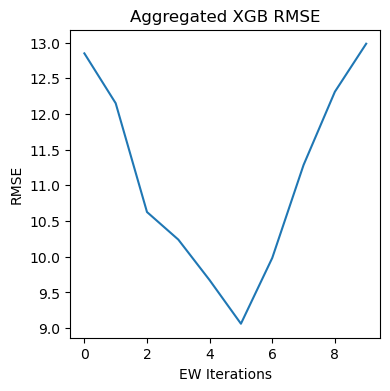

In [21]:
plt.figure(figsize=(4, 4)) 
plt.plot(col1)
plt.title('Aggregated XGB RMSE')
plt.ylabel('RMSE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

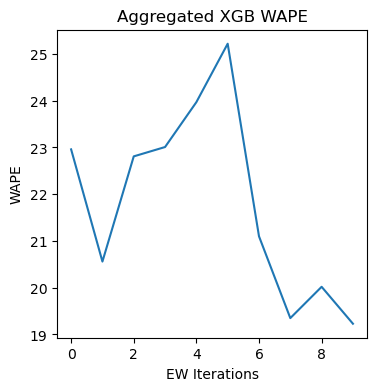

In [22]:
plt.figure(figsize=(4, 4)) 
plt.plot(col2)
plt.title('Aggregated XGB WAPE')
plt.ylabel('WAPE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

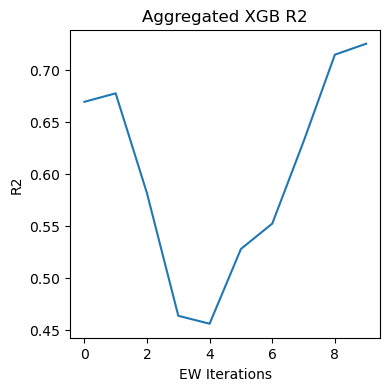

In [23]:
plt.figure(figsize=(4, 4)) 
plt.plot(col3)
plt.title('Aggregated XGB R2')
plt.ylabel('R2')
plt.xlabel('EW Iterations')

# Random Forest

In [24]:
metrics_list_rf = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, cuRF())
    metrics_list_rf.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 11.9463
WAPE: 21.12
R2: 0.7139

Elapsed time: 0.524 seconds

Iteration  1
RMSE: 11.6925
WAPE: 19.43
R2: 0.7010

Elapsed time: 0.612 seconds

Iteration  2


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 10.1511
WAPE: 21.67
R2: 0.6180

Elapsed time: 0.698 seconds

Iteration  3
RMSE: 9.7865
WAPE: 21.77
R2: 0.5103

Elapsed time: 0.801 seconds

Iteration  4


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 9.2549
WAPE: 23.18
R2: 0.5022

Elapsed time: 0.897 seconds

Iteration  5
RMSE: 8.7737
WAPE: 24.68
R2: 0.5575

Elapsed time: 0.989 seconds

Iteration  6


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 9.7487
WAPE: 20.59
R2: 0.5730

Elapsed time: 1.075 seconds

Iteration  7
RMSE: 10.8490
WAPE: 18.27
R2: 0.6589

Elapsed time: 1.129 seconds

Iteration  8


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 11.6701
WAPE: 18.86
R2: 0.7432

Elapsed time: 1.189 seconds

Iteration  9
RMSE: 12.5163
WAPE: 18.64
R2: 0.7443

Elapsed time: 1.248 seconds


In [25]:
rmse_rf, wape_rf, r2_rf = total_averaged_metrics(metrics_list_rf)

Total Averaged RMSE: 10.639
Total Averaged WAPE: 20.821
Total Averaged R2: 0.632


In [26]:
metrics_list_rf

[(11.9463, 21.12, 0.7139),
 (11.6925, 19.43, 0.701),
 (10.1511, 21.67, 0.618),
 (9.7865, 21.77, 0.5103),
 (9.2549, 23.18, 0.5022),
 (8.7737, 24.68, 0.5575),
 (9.7487, 20.59, 0.573),
 (10.849, 18.27, 0.6589),
 (11.6701, 18.86, 0.7432),
 (12.5163, 18.64, 0.7443)]

In [27]:
col1 = [row[0] for row in metrics_list_rf]
col2 = [row[1] for row in metrics_list_rf]
col3 = [row[2] for row in metrics_list_rf]

Text(0.5, 0, 'EW Iterations')

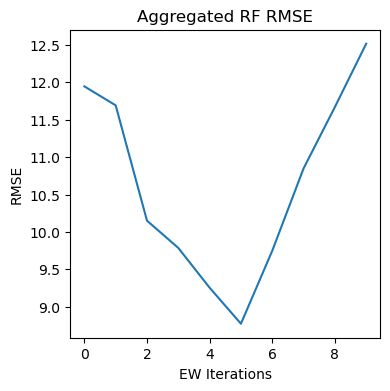

In [28]:
# Plot for the first column
plt.figure(figsize=(4, 4)) # 1 row, 3 columns, 1st position
plt.plot(col1)
plt.title('Aggregated RF RMSE')
plt.ylabel('RMSE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

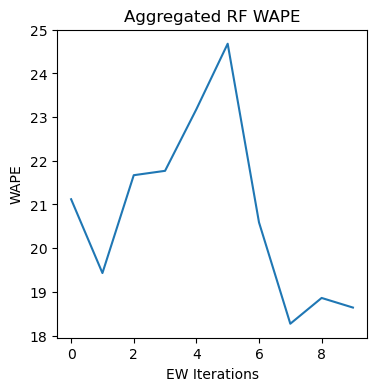

In [29]:
# Plot for the second column
plt.figure(figsize=(4, 4))
plt.title('Aggregated RF WAPE')
plt.plot(col2)
plt.ylabel('WAPE')
plt.xlabel('EW Iterations')

Text(0.5, 0, 'EW Iterations')

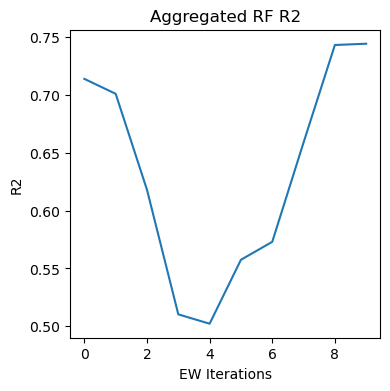

In [30]:
# Plot for the third column
plt.figure(figsize=(4, 4))
plt.title('Aggregated RF R2')
plt.plot(col3)
plt.ylabel('R2')
plt.xlabel('EW Iterations')

# Feature Selection

<Axes: >

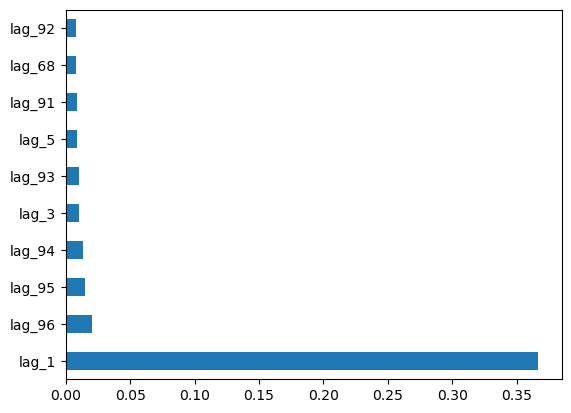

In [31]:
feature_importance = pd.Series(model_xgb.feature_importances_, index=X.columns)
feature_importance.nlargest(10).plot(kind='barh')

In [32]:
features = feature_importance.nlargest(10).index
X_selected = X.loc[:,features]
X_selected

,lag_1,lag_96,lag_95,lag_94,lag_3,lag_93,lag_5,lag_91,lag_68,lag_92
0,60.185391,58.514142,57.575249,63.011688,39.668909,62.735722,46.399861,63.710440,47.781851,63.404029
1,75.988362,57.575249,63.011688,62.735722,66.805930,63.404029,63.415043,50.544573,48.816634,63.710440
2,73.248235,63.011688,62.735722,63.404029,60.185391,63.710440,39.668909,49.966228,49.752752,50.544573
3,29.228225,62.735722,63.404029,63.710440,75.988362,50.544573,66.805930,50.950286,49.738363,49.966228
4,26.668414,63.404029,63.710440,50.544573,73.248235,49.966228,60.185391,53.039862,52.573781,50.950286
...,...,...,...,...,...,...,...,...,...,...
35035,62.642645,59.032763,61.748938,68.822483,42.250176,52.902303,46.176803,63.639275,32.924713,65.831927
35036,49.211311,61.748938,68.822483,52.902303,39.394640,65.831927,46.691361,61.680151,29.438008,63.639275
35037,43.139892,68.822483,52.902303,65.831927,62.642645,63.639275,42.250176,68.210391,30.097502,61.680151
35038,44.599341,52.902303,65.831927,63.639275,49.211311,61.680151,39.394640,64.340362,61.888162,68.210391


# Hyper-parameter tuning

In [33]:
params_xgb = { 
    'max_depth': [3,6,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'colsample_bytree': [0.3, 0.7],
}

In [34]:
params_rf = {
    'max_depth': [8, 16, 24, 30],
    'max_batch_size': [2, 32, 128],
    'min_samples_split': [2, 10],
    'n_estimators': [100, 250, 500]
}

In [67]:
xgb_model = xgb.XGBRegressor(tree_method="gpu_hist", seed=42)
grid_search = GridSearchCV(estimator = xgb_model, param_grid = params_xgb, cv = 5, n_jobs = 4, verbose = 1, scoring="r2")
grid_search.fit(X_selected, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.3, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='r2', verbose=1)

In [68]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.7,
  'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 1000},
 0.6772970099532964)

In [35]:
xgb_params = ({'colsample_bytree': 0.7,
  'learning_rate': 0.01,
  'max_depth': 3,
  'n_estimators': 1000})
 #0.6772970099532964)

In [69]:
xgb_params = grid_search.best_params_

In [70]:
rf = cuRF()
grid_search_rf = GridSearchCV(estimator = rf, param_grid = params_rf, cv = 5, n_jobs = 8, verbose = 1, scoring="r2")
grid_search_rf.fit(X_selected, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/minico

In [ ]:
grid_search_rf.best_params_, grid_search_rf.best_score_

### Linear Regression (after feature selection)

In [36]:
metrics_list_lr_sel = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X_selected, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, LinearRegression())
    metrics_list_lr_sel.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 11.4093
WAPE: 19.45
R2: 0.7391

Elapsed time: 0.007 seconds

Iteration  1
RMSE: 11.6225
WAPE: 19.33
R2: 0.7046

Elapsed time: 0.004 seconds

Iteration  2
RMSE: 10.0520
WAPE: 21.13
R2: 0.6254

Elapsed time: 0.003 seconds

Iteration  3
RMSE: 9.7273
WAPE: 21.62
R2: 0.5162

Elapsed time: 0.004 seconds

Iteration  4
RMSE: 8.9810
WAPE: 21.85
R2: 0.5312

Elapsed time: 0.004 seconds

Iteration  5
RMSE: 8.3596
WAPE: 22.52
R2: 0.5983

Elapsed time: 0.005 seconds

Iteration  6
RMSE: 9.6197
WAPE: 20.15
R2: 0.5842

Elapsed time: 0.005 seconds

Iteration  7
RMSE: 10.5721
WAPE: 17.69
R2: 0.6761

Elapsed time: 0.005 seconds

Iteration  8
RMSE: 11.1976
WAPE: 17.84
R2: 0.7636

Elapsed time: 0.006 seconds

Iteration  9
RMSE: 12.2234
WAPE: 17.80
R2: 0.7561

Elapsed time: 0.006 seconds


In [37]:
rmse_lr_sel, wape_lr_sel, r2_lr_sel = total_averaged_metrics(metrics_list_lr_sel)

Total Averaged RMSE: 10.376
Total Averaged WAPE: 19.938
Total Averaged R2: 0.649


### XGBoost (after feature selection + hyper tuning)

In [38]:
metrics_list_xgb_sel = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X_selected, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, model_xgb = predict_results(X_train_norm, X_test_norm, y_train, y_test, xgb.XGBRegressor(seed=42, tree_method='gpu_hist', colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=1000))
    metrics_list_xgb_sel.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0
RMSE: 11.5607
WAPE: 19.69
R2: 0.7321

Elapsed time: 0.489 seconds

Iteration  1
RMSE: 11.6199
WAPE: 19.30
R2: 0.7047

Elapsed time: 0.421 seconds

Iteration  2
RMSE: 10.0957
WAPE: 21.26
R2: 0.6222

Elapsed time: 0.428 seconds

Iteration  3
RMSE: 9.7832
WAPE: 21.70
R2: 0.5106

Elapsed time: 0.425 seconds

Iteration  4
RMSE: 8.9890
WAPE: 21.84
R2: 0.5304

Elapsed time: 0.428 seconds

Iteration  5
RMSE: 8.3535
WAPE: 22.61
R2: 0.5989

Elapsed time: 0.430 seconds

Iteration  6
RMSE: 9.6448
WAPE: 20.14
R2: 0.5821

Elapsed time: 0.431 seconds

Iteration  7
RMSE: 10.5998
WAPE: 17.77
R2: 0.6744

Elapsed time: 0.442 seconds

Iteration  8
RMSE: 11.3669
WAPE: 17.95
R2: 0.7564

Elapsed time: 0.444 seconds

Iteration  9
RMSE: 12.2275
WAPE: 17.83
R2: 0.7559

Elapsed time: 0.446 seconds


In [39]:
rmse_xgb_sel, wape_xgb_sel, r2_xgb_sel = total_averaged_metrics(metrics_list_xgb_sel)

Total Averaged RMSE: 10.424
Total Averaged WAPE: 20.009
Total Averaged R2: 0.647


### Random Forest (after feature selection + hyper tuning)

In [40]:
metrics_list_rf_sel = []

for i in range(n_splits):
    start = time.time()
    print("\nIteration ", i)


    X_train, X_test, y_train, y_test = expanding_window_split(X_selected, y, cv=i, n_splits=n_splits)

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    rmse, wape, r2, _ = predict_results(X_train_norm, X_test_norm, y_train, y_test, cuRF(max_depth=8, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=500))
    metrics_list_rf_sel.append((rmse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))


Iteration  0


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 15.6087
WAPE: 28.20
R2: 0.5117

Elapsed time: 0.823 seconds

Iteration  1
RMSE: 15.4709
WAPE: 27.08
R2: 0.4766

Elapsed time: 0.834 seconds

Iteration  2


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 13.2280
WAPE: 29.38
R2: 0.3514

Elapsed time: 0.851 seconds

Iteration  3
RMSE: 12.8481
WAPE: 29.96
R2: 0.1561

Elapsed time: 0.862 seconds

Iteration  4


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 11.9503
WAPE: 31.03
R2: 0.1701

Elapsed time: 0.865 seconds

Iteration  5
RMSE: 11.3168
WAPE: 33.53
R2: 0.2638

Elapsed time: 0.889 seconds

Iteration  6


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 12.5287
WAPE: 27.89
R2: 0.2948

Elapsed time: 0.893 seconds

Iteration  7
RMSE: 13.7424
WAPE: 24.37
R2: 0.4527

Elapsed time: 0.909 seconds

Iteration  8


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


RMSE: 15.4713
WAPE: 26.08
R2: 0.5487

Elapsed time: 0.911 seconds

Iteration  9
RMSE: 16.5539
WAPE: 25.61
R2: 0.5527

Elapsed time: 0.935 seconds


In [41]:
rmse_rf_sel, wape_rf_sel, r2_rf_sel = total_averaged_metrics(metrics_list_rf_sel)

Total Averaged RMSE: 13.872
Total Averaged WAPE: 28.313
Total Averaged R2: 0.378


In [53]:
all_rmse = (rmse_15/100, rmse_lr/100, rmse_lr_sel/100, rmse_rf/100, rmse_rf_sel/100, rmse_xgb/100, rmse_xgb_sel/100)

In [57]:
all_wape = (wape_15, wape_lr/100, wape_lr_sel/100, wape_rf/100, wape_rf_sel/100, wape_xgb/100, wape_xgb_sel/100)

In [55]:
all_r2 = (r2_15, r2_lr, r2_lr_sel, r2_rf, r2_rf_sel, r2_xgb, r2_xgb_sel)

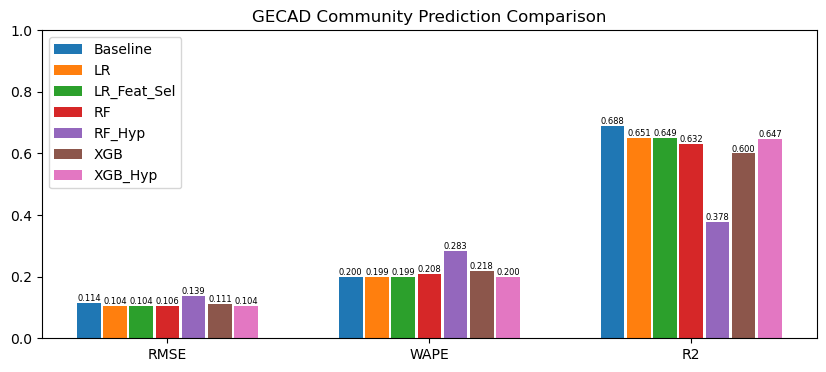

In [61]:
model_names = ("Baseline", "LR", "LR_Feat_Sel", "RF", "RF_Hyp", "XGB", "XGB_Hyp")
X_names = ['RMSE', 'WAPE', 'R2']
X_axis = np.arange(len(X_names))
pos = -0.15
bar_width = 0.1
fig, ax = plt.subplots(figsize=(10,4))

for i in range(len(model_names)):
    bar = (all_rmse[i], all_wape[i], all_r2[i])
    b = ax.bar(X_axis + pos, bar, bar_width-0.01, label=model_names[i])
    pos = pos + bar_width
    ax.bar_label(b, fontsize=6, fmt='%.3f')
    
ax.set_ylim(0,1)
ax.set_xticks(X_axis+bar_width+bar_width/2,X_names)
#ax.set_ylabel("Metrics")
ax.set_title("GECAD Community Prediction Comparison")
ax.legend()
#plt.savefig(filename)
plt.show()

# Polynomial Regression

### Test for last 8 energy points (2 hours) degree 2, 3 and 4

In [ ]:
degree_list = []
full_start = time.time()
for degree in range(2,5):
    metrics_list = []
    print("\n\t\tDegree ", degree)
    for i in range(1,number_of_past_timesteps+1):
        start = time.time()
        print("\nIteration ", i)
        X, y = last_energy_points(df_total, i)
        X_train, X_test, y_train, y_test = prepare_polynomial(X, y, deg=degree)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        X_train_norm, scaler = normalize_training(X_train)
        X_test_norm = scaler.transform(X_test)
        y_train_norm, scaler2 = normalize_training(y_train)
        y_test_norm = pd.DataFrame(scaler2.transform(y_test))
        
        rmse, wape, r2 = predict_results(X_train_norm, X_test_norm, y_train_norm, y_test_norm, LinearRegression())
        print()
        metrics_list.append((rmse,wape,r2))      
        print("\nElapsed time: %.3f seconds" % (time.time() - start))
    degree_list.append(metrics_list)
print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))